In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
# from PIL import Image, ImageDraw
print('tf version :',tf.__version__)
print('tf gpu available :',tf.test.is_gpu_available())

tf version : 2.0.0
tf gpu available : True


# Data load

In [2]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
print('train data & labels shape:',x_train.shape, y_train.shape)

train data & labels shape: (5121, 64, 64) (5121,)


In [3]:
apple_train = x_train[y_train==0]
print(apple_train.shape)

(1719, 64, 64)


# Data visualize

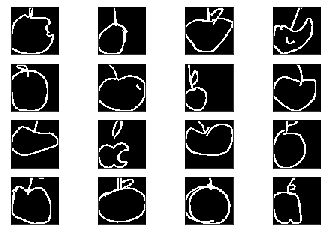

In [4]:
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(apple_train[i*100],cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()

# Data preprocess for train

In [5]:
real_images = apple_train[..., tf.newaxis] # (1719, 64,64,1)
print('real_image shape :', real_images.shape)

train_ds = tf.data.Dataset.from_tensor_slices(real_images).shuffle(10000).batch(128)


real_image shape : (1719, 64, 64, 1)


# Generator model

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*32, use_bias=False))
    model.add(layers.BatchNormalization(axis=-1, momentum=0.9))
    model.add(layers.Activation(activation='relu'))
    model.add(layers.Reshape((8,8,32)))
    model.add(layers.Dropout(0.4))
    
    # Convolutional layers
    model.add(layers.UpSampling2D()) #8, 8 ,32
    model.add(layers.Conv2DTranspose(32, kernel_size=5, padding='same'))
    model.add(layers.BatchNormalization(axis=-1,momentum=0.9))
    model.add(layers.Activation(activation='relu'))
    
    model.add(layers.UpSampling2D()) #16,16,16
    model.add(layers.Conv2DTranspose(16, kernel_size=5, padding='same'))
    model.add(layers.BatchNormalization(axis=-1,momentum=0.9))
    model.add(layers.Activation(activation='relu'))
    
    model.add(layers.UpSampling2D())# (32,32,8
    model.add(layers.Conv2DTranspose(8, kernel_size=5, padding='same'))
    model.add(layers.BatchNormalization(axis=-1, momentum=0.9))
    model.add(layers.Activation(activation='relu'))
    
    model.add(layers.Conv2D(1, kernel_size=5, padding='same',activation = 'sigmoid')) #64,64,1

    return model

In [7]:
generator = make_generator_model()
# tf.keras.utils.plot_model(generator)

# Discriminator model

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, 5, strides=2, padding='same', activation=None))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(32, 5, strides=2, padding='same', activation=None))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(16, 5, strides=2, padding='same', activation=None))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(8, 5, strides=2, padding='same', activation=None))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [9]:
discriminator = make_discriminator_model()
# tf.keras.utils.plot_model(disscriminator)

# Define loss & optimizer

In [10]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss(tf.ones(real_output.shape[0],),
                     real_output)
    
    fake_loss = loss(tf.zeros(fake_output.shape[0],) #(batch_size, )
                     , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return loss(tf.ones(fake_output.shape[0],), fake_output)

In [11]:
learning_rate = 0.0001
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# check point

In [12]:
import os
model_save_path = 'apple2_model_save'
img_save_path = 'apple2_save_fig'
if not os.path.isdir(model_save_path):
    os.mkdir(model_save_path)

if not os.path.isdir(img_save_path):
    os.mkdir(img_save_path)


checkpoint_dir = model_save_path
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Train function

In [13]:
@tf.function
def train_step(images):
    noise = np.random.normal(size=(32,100,))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [18]:
test_input = np.random.normal(size=(100,))[tf.newaxis,...]

g_losses = []
d_losses = []
def train(dataset, epochs):
    print('training start')
    for epoch in range(2564,epochs):
        start = time.time()
        
        gen_loss, dis_loss = 0, 0

        for i, image_batch in enumerate(dataset):
            g_batch_loss, d_batch_loss = train_step(image_batch)
            gen_loss += g_batch_loss
            dis_loss += d_batch_loss
        
        # save
        g_losses.append(gen_loss/i)
        d_losses.append(dis_loss/i)


        if (epoch +1) % 10 ==0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            # for gen img checking per epoch
            gen_img = tf.squeeze(generator(test_input))
            plt.imshow(gen_img,cmap='gray')
            plt.xticks([]);plt.yticks([])
            plt.savefig(img_save_path + '/test_img_{:04d}epoch'.format(epoch+1))
            print('===============check point===============')
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
        print('gen loss : {}     dis loss : {}'.format(g_losses[-1],d_losses[-1]))        

    print('Train Done')

In [ ]:
train(train_ds,3000)

training start
Time for epoch 2565 is 1.0893702507019043 sec
gen loss : 0.6986573934555054     dis loss : 1.1771502494812012
Time for epoch 2566 is 1.0352199077606201 sec
gen loss : 0.696287214756012     dis loss : 1.1889070272445679
Time for epoch 2567 is 1.035759687423706 sec
gen loss : 0.696822464466095     dis loss : 1.184322476387024
Time for epoch 2568 is 1.0342395305633545 sec
gen loss : 0.6976442933082581     dis loss : 1.1890952587127686
Time for epoch 2569 is 1.0360453128814697 sec
gen loss : 0.7017268538475037     dis loss : 1.180530071258545
===============check point===============
Time for epoch 2570 is 1.5817701816558838 sec
gen loss : 0.6953785419464111     dis loss : 1.1898232698440552
Time for epoch 2571 is 1.0569746494293213 sec
gen loss : 0.6969813108444214     dis loss : 1.1820813417434692
Time for epoch 2572 is 1.0392327308654785 sec
gen loss : 0.695651113986969     dis loss : 1.1876152753829956
Time for epoch 2573 is 1.0351407527923584 sec
gen loss : 0.7039894461

In [16]:
noise_test = np.random.normal(size=(16,100,))
images = generator(noise_test)

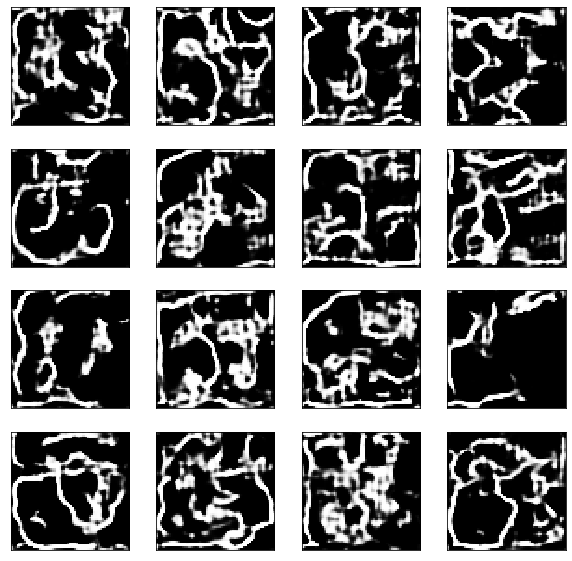

In [17]:
plt.rcParams["figure.figsize"] = (10,10)
for i in range(16):
    image = tf.squeeze(images[i])
    plt.subplot(4,4,i+1)
    plt.imshow(image,cmap='gray')
    plt.xticks([]);plt.yticks([])
plt.show()
    